In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numpy import asarray

from tdse.propagator._base import Wavefunction

class Wavefunction_on_Spherical_Box_with_single_m(Wavefunction):
    """
    A specification object for wavefunction defined on a spherical box
    with a single azimuthal quantum number `m`
    """
    
    dim = 3
    
    @staticmethod
    def get_r_arr(Nr, dr):
        _r_arr = dr * np.arange(1, Nr+1)
        return _r_arr
    
    @classmethod
    def norm_sq(cls, wf, dr):
        """Evalaute the norm square of the given wavefunction array
        
        Parameters
        ----------
        wf : (..., Nlm, Nr) array-like
            a single or an array of wavefunction arrays
            with each wavefunction of shape (Nlm, Nr)
        dr : float
            a grid spacing of the radial grid
        """
        _wf = asarray(wf)
        _Nr = _wf.shape[-1]
        _r_arr = cls.get_r_arr(_Nr, dr)
        _wf_abs_sq = np.real(_wf.conj() * _wf)
        _norm_sq_lm = np.sum(_wf_abs_sq, axis=-1)
        _norm_sq_total = np.sum(_norm_sq_lm, axis=-1)
        return _norm_sq_total

In [3]:
from numbers import Integral

import numpy as np

from tdse.evol import (get_M2_tridiag, get_D2_tridiag, 
                       mul_tridiag_and_diag)
from tdse.tridiag import tridiag_forward, tridiag_backward

from tdse.propagator._base import Propagator

class Propagator_on_Spherical_Box_with_single_m(Propagator):
    """
    Propagator designed to propagate a wavefunction 
    defined on a spherical box with single azimuthal quantum number m
    
    The wavefunction is expanded by a set of spherical harmonics.
    The radial functions are discretized on a uniform grid,
    i.e. with a fixed grid spacing."""
    
    wf_class = Wavefunction_on_Spherical_Box_with_single_m
    
    def __init__(self, Nr, dr, m, lmax, Vr=0.0, hbar=1.0, mass=1.0):
        
        # Check argumetns
        if Nr != int(Nr) or not (Nr > 0):
            _msg = "`Nr` should be a positive integer. Given: {}"
            raise ValueError(_msg.format(Nr))
        self.Nr = int(Nr)
        
        if not (float(dr) > 0):
            _msg = "`dr` should be a positive real number. Given: {}"
            raise ValueError(_msg.format(dr))
        self.dr = float(dr)
        
        if not isinstance(m, Integral) or m < 0:
            _msg = "`m` should be a nonnegative integer. Given: {}"
            raise ValueError(_msg.format(m))
        self.m = m
        
        if not isinstance(lmax, Integral) or lmax < m:
            _msg = "`lmax` should be an integer and `>= m`. Given: {}"
            raise ValueError(_msg.format(lmax))
        self.lmax = lmax
        
        self.hbar, self.mass = hbar, mass
        
        self.l = np.arange(self.m, self.lmax+1, dtype=int)
        _Nl = self.l.size
        self.Nlm = _Nl
        self.lm = np.array([(l,self.m) for l in self.l], dtype=int)
        
        self.r_arr = self.dr * np.arange(1, self.Nr+1)
        self.r_max = self.r_arr[-1] + dr
        
        if Vr == 0.0: self.Vr = np.zeros((self.Nr,), dtype=np.float)
        else:
            _Vr = asarray(Vr)
            if _Vr.shape != (self.Nr,):
                _msg = "`Vr` should be of shape ({},). Given shape: {}"
                raise ValueError(_msg.format(self.Nr, _Vr.shape))
            self.Vr = _Vr
        
        _D2 = get_D2_tridiag(self.Nr, self.dr)
        self.M2 = get_M2_tridiag(self.Nr)
        
        # Correction for Coulomb potential
#         _D2[1,0] = 
#         self.M2[1,0] = 
        
        _M2Hl_shape = (self.Nlm,) + self.M2.shape
        self.M2Hl = np.empty(_M2Hl_shape, dtype=self.Vr.dtype)
        _hbar_sq_over_2mass = self.hbar**2 / (2.*self.mass)
        _Kr = - _hbar_sq_over_2mass * _D2
        _r_sq = np.square(self.r_arr)
        for _il, _l in enumerate(self.l):
            _Vl = _hbar_sq_over_2mass * _l * (_l+1) / _r_sq + self.Vr
            _M2Vl = mul_tridiag_and_diag(self.M2, _Vl)
            self.M2Hl[_il] = _Kr + _M2Vl
            
    def propagate(self, wf, dt, Nt=1):
        if Nt < 0: raise ValueError(
            "Nt should be a nonnegative integer. Given: {}".format(Nt))
        _FO = (-0.5j*dt/self.hbar) * self.M2Hl
        _Uf_half = self.M2 + _FO # unitary half timestep prop forward
        _Ub_half = self.M2 - _FO # unitary half timestep prop backward
        _wf_lm_mid = np.empty((self.Nr,), dtype=wf.dtype)
        for _it in range(Nt):
            for _ilm in range(self.Nlm):
                tridiag_forward(_Uf_half[_ilm], wf[_ilm], _wf_lm_mid)
                tridiag_backward(_Ub_half[_ilm], wf[_ilm], _wf_lm_mid)
    
    def propagate_to_ground_state(self, wf=None, dt=None, max_Nt=20000,
                                  Nt_per_iter=10, norm_thres=1e-13):
        _dt = dt
        if dt is None: _dt = self.dr / 4.
        
        if wf is None: 
            _wf = np.empty((self.Nlm, self.Nr), dtype=np.complex)
            _wf[:] = np.random.rand(*_wf.shape)
        else: _wf = np.asarray(wf)
            
        _normalizer_args = (self.dr,)
        super().propagate_to_ground_state(_wf, _dt, max_Nt,
            _normalizer_args, Nt_per_iter, norm_thres)
        
        if wf is None: return _wf

In [4]:
prop = Propagator_on_Spherical_Box_with_single_m(
    Nr=51, dr=0.2, m=0, lmax=0, Vr=0.0)

In [5]:
wf_t0 = prop.propagate_to_ground_state(norm_thres=1e-10)

iteration count at end: 72


In [6]:
wf = wf_t0.copy()

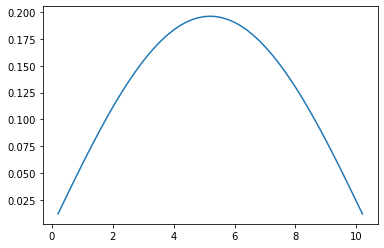

In [7]:
fig, ax = plt.subplots()
for ilm, (l,m) in enumerate(prop.lm):
    ax.plot(prop.r_arr, wf[ilm].real)

#### Analytical solution

In [8]:
from tdse.analytic import spherical_jn_zeros

jl_zero_1 = spherical_jn_zeros(0, 1)

In [9]:
from scipy.special import spherical_jn

R00 = spherical_jn(0, (jl_zero_1 / prop.r_max) * prop.r_arr)
g00 = prop.r_arr * R00
prop.wf_class.normalize(g00, prop.dr)

#### Comparison : analytical - numerical

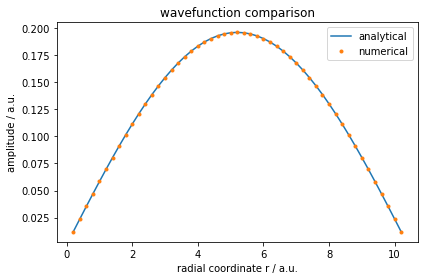

In [10]:
fig, ax = plt.subplots()

ax.plot(prop.r_arr, g00.real, label='analytical')
ax.plot(prop.r_arr, wf[0].real, '.', label='numerical')

ax.legend()
ax.set_xlabel("radial coordinate r / a.u.")
ax.set_ylabel("amplitude / a.u.")
ax.set_title("wavefunction comparison")
fig.tight_layout()

# fig.savefig("state-analytical-comparison-test-1.png")

#### Evalaute the raidal function $R_{lm}(r,t) \equiv \frac{1}{r}g_{lm}(r,t)$

In [11]:
Rm = wf[0,:] / prop.r_arr

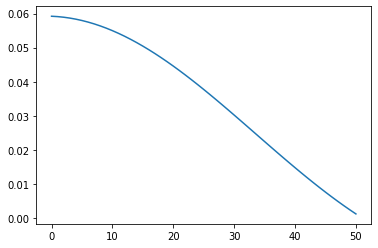

In [12]:
fig, ax = plt.subplots()
ax.plot(Rm.real)

# Real Propagation

In [13]:
dt, Niter, Nt_per_iter = 0.05, 32, 101
t_arr = dt * Nt_per_iter * np.arange(Niter)

In [14]:
wf = np.empty_like(wf_t0, dtype=np.complex)
wf[:] = wf_t0
wf_t = np.empty((Niter,)+wf_t0.shape, dtype=np.complex)
wf_t[0] = wf
for it in range(Niter-1):
    prop.propagate(wf, dt, Nt=Nt_per_iter)
    wf_t[it+1] = wf

In [15]:
from vis.plot import construct_catesian_mesh_for_pcolormesh
t_cmesh, r_cmesh = construct_catesian_mesh_for_pcolormesh(t_arr, prop.r_arr)

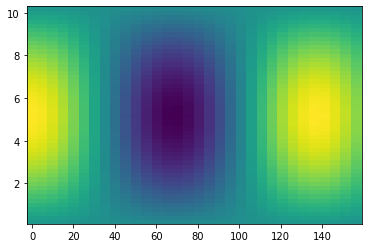

In [16]:
fig, ax = plt.subplots()
ax.pcolormesh(t_cmesh, r_cmesh, wf_t[:,0,:].real)